In [ ]:
# 1. Import libraries

import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras import models, layers
from keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense
from tensorflow.keras.metrics import Recall

**1. IMPORTING THE DATA**

In [ ]:
def preprocess_data(filepath, n_attr, m_yrs, label):
    # Load the data, assuming no headers and skipping blank rows
    df = pd.read_csv(filepath, header=None, skip_blank_lines=True)

    # Drop any rows that are entirely NaN, which might represent blank lines not caught by skip_blank_lines
    df.dropna(how='all', inplace=True)

    # Each company's data consists of n_attr rows, reset index to make slicing consistent
    df.reset_index(drop=True, inplace=True)

    # Calculate the number of companies by dividing the length of df by the rows per company
    num_companies = len(df) // n_attr
    data = np.zeros((num_companies, m_yrs, n_attr))
    labels = np.full((num_companies,), label)  # Label array filled with the input label

    for i in range(num_companies):
        # Extract the rows for one company
        start_idx = i * n_attr
        end_idx = start_idx + n_attr
        company_data = df.iloc[start_idx:end_idx]

        # Transpose the data to fit [year, attribute] format
        company_data = company_data.transpose().values

        # Store in the data array
        data[i, :, :] = company_data

    return data, labels

def split_data(data, labels, proportions):
    """ Split data based on given proportions for training, validation, and test sets. """
    np.random.seed(1)
    indices = np.random.permutation(len(data))
    data, labels = data[indices], labels[indices]

    train_end = int(proportions[0] * len(data))
    val_end = train_end + int(proportions[1] * len(data))

    return (data[:train_end], labels[:train_end]), (data[train_end:val_end], labels[train_end:val_end]), (data[val_end:], labels[val_end:])

# Constants for the number of attributes and years
n_attr = 28
m_yrs = 5

# Load and label the data
bc_data, bc_labels = preprocess_data("BankruptedCompanies.csv", n_attr, m_yrs, 1)
hc_data, hc_labels = preprocess_data("HealthyCompanies1.csv", n_attr, m_yrs, 0)  # Assuming you'll also process HealthyCompanies2.csv similarly

# Combine bankrupt and healthy data and labels
all_data = np.concatenate([bc_data, hc_data], axis=0)
all_labels = np.concatenate([bc_labels, hc_labels], axis=0)

# Split the combined data into training, validation, and test sets
(train_data, train_labels), (val_data, val_labels), (test_data, test_labels) = split_data(all_data, all_labels, [0.6, 0.2])

# Store in variables for use in classification
x_train, y_train = train_data, train_labels
x_val, y_val = val_data, val_labels
x_test, y_test = test_data, test_labels

**2. BUILDING THE MODEL**

In [ ]:
model = models.Sequential()
model.add(layers.LSTM(75, activation='relu',
input_shape=(m_yrs, n_attr),return_sequences=True))
model.add(layers.LSTM(50, activation='relu'))
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=["acc",Recall()])

history = model.fit(x_train, y_train, epochs=20, batch_size=32,
validation_data=(x_val,y_val))

Epoch 1/20
359/359 [==============================] - 17s 23ms/step - loss: 8.8486 - acc: 0.9515 - recall: 0.0455 - val_loss: 1.1860 - val_acc: 0.9741 - val_recall: 0.0580
Epoch 2/20
359/359 [==============================] - 4s 10ms/step - loss: 1.2290 - acc: 0.9704 - recall: 0.0124 - val_loss: 0.3764 - val_acc: 0.9772 - val_recall: 0.0145
Epoch 3/20
359/359 [==============================] - 5s 14ms/step - loss: 0.7410 - acc: 0.9731 - recall: 0.0165 - val_loss: 0.3583 - val_acc: 0.9791 - val_recall: 0.0145
Epoch 4/20
359/359 [==============================] - 4s 11ms/step - loss: 1.0396 - acc: 0.9753 - recall: 0.0537 - val_loss: 0.4543 - val_acc: 0.9796 - val_recall: 0.0145
Epoch 5/20
359/359 [==============================] - 4s 10ms/step - loss: 0.4097 - acc: 0.9760 - recall: 0.0620 - val_loss: 0.5956 - val_acc: 0.9786 - val_recall: 0.0290
Epoch 6/20
359/359 [==============================] - 4s 10ms/step - loss: 0.7695 - acc: 0.9759 - recall: 0.1033 - val_loss: 0.8983 - val_acc: 0

**3. VISUALIZING THE RESULT**

Loss: 0.27817463874816895, Accuracy: 0.9769874215126038, Recall: 0.25882354378700256
120/120 [==============================] - 1s 4ms/step


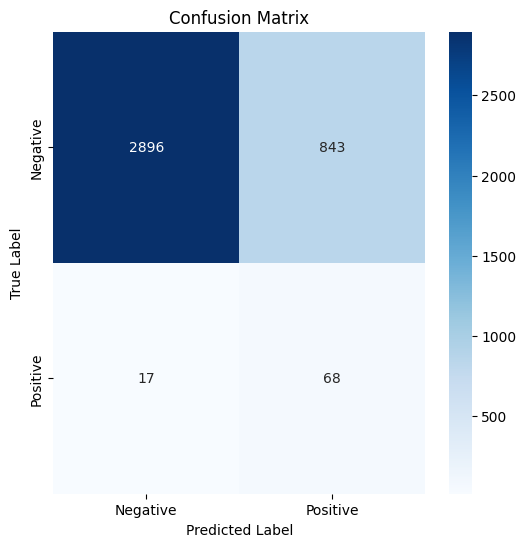

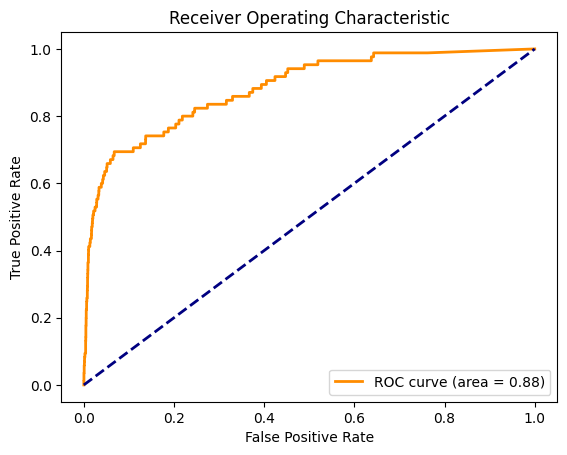

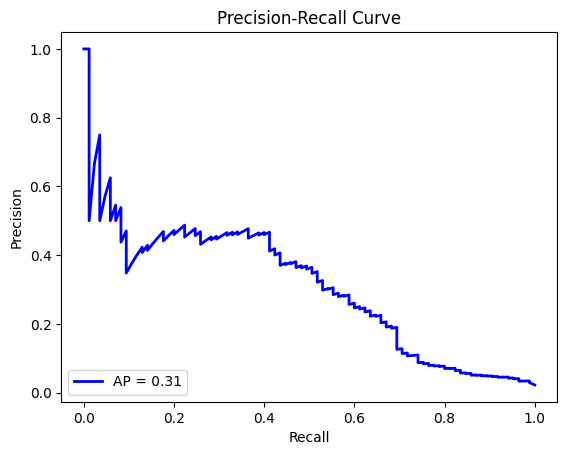

In [ ]:
loss, accuracy, recall = model.evaluate(x_test, y_test, verbose=0)
print(f"Loss: {loss}, Accuracy: {accuracy}, Recall: {recall}")

# Predict probabilities for the test data
y_probs = model.predict(x_test)

# Binarize predictions based on a threshold of 0.5
y_pred = (y_probs > 0.2).astype('int32')

# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
ap = average_precision_score(y_test, y_probs)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()